In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import os
from collections import defaultdict

## Predictive Model

In [4]:
excel = pd.ExcelFile(r"IFC_LiDAR_Plots_RTK.xlsx", engine='openpyxl')
df = excel.parse('IFC - Plots Consistido')

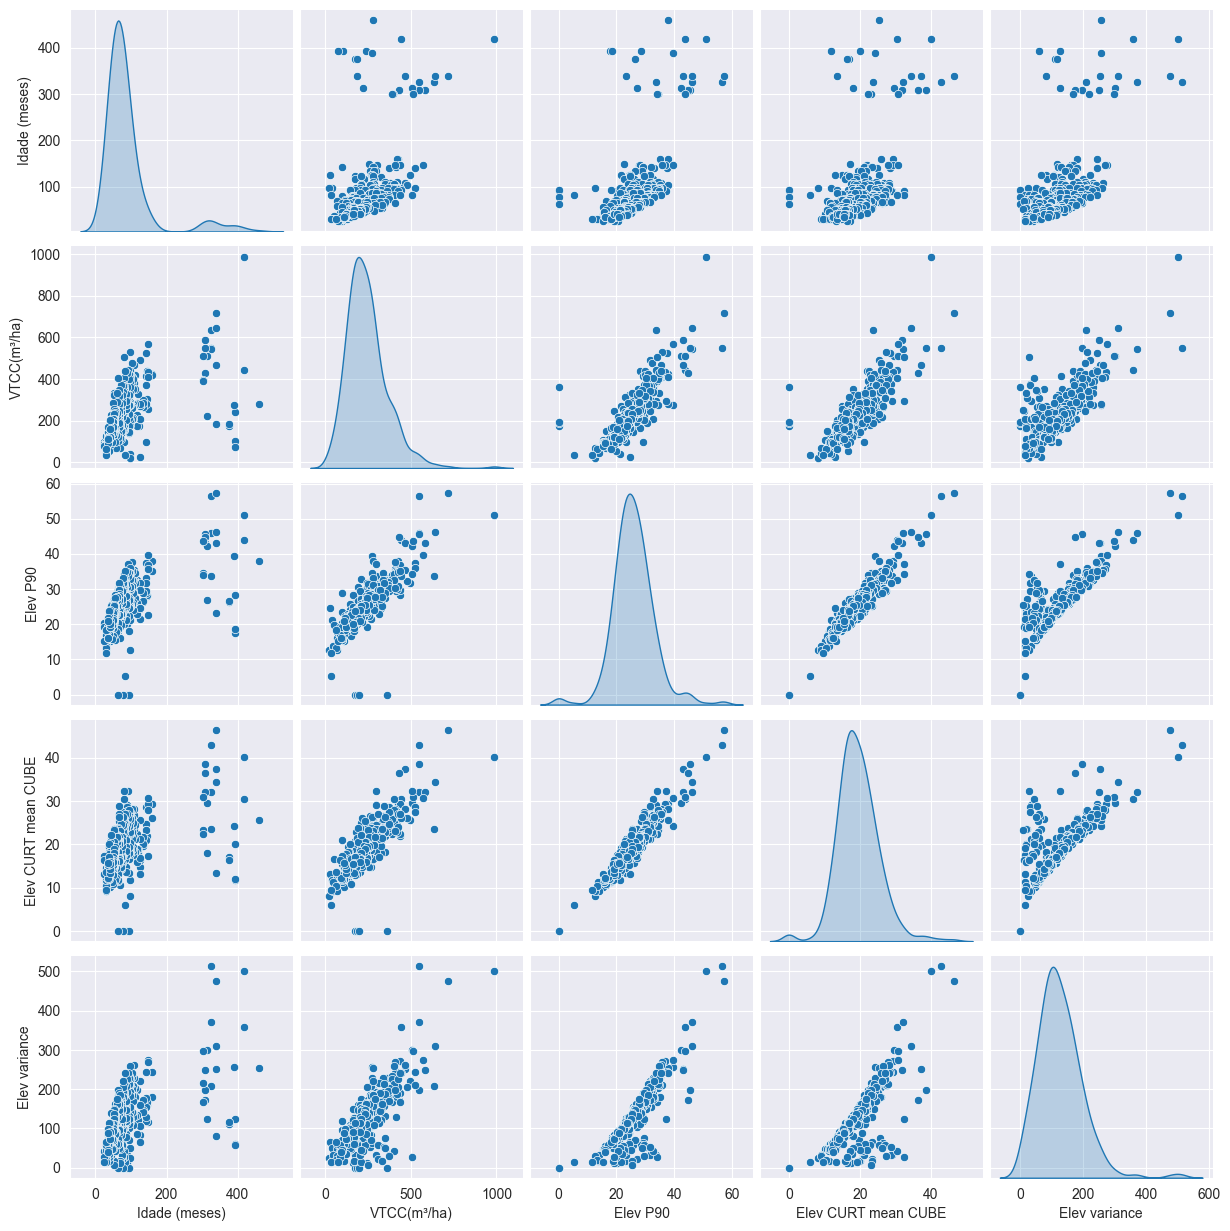

In [5]:
sns.pairplot(df[['Idade (meses)', 'VTCC(m³/ha)',"Elev P90", "Elev CURT mean CUBE", 'Elev variance']], diag_kind="kde")
plt.show()

In [6]:
# Filter data to exclude undesired values
df = df[
    (df['VTCC(m³/ha)'] > 80) &
    (df['Idade (meses)'] < 200) &
    (df['Elev P90'] > 10) &
    (df['Regime'] != 'IMP') &
    ~((df['VTCC(m³/ha)'] > 160) & (df['Elev variance'] < 50)) &
    ~((df['Elev P90'] > 18) & (df['Elev variance'] < 40)) &
    ~((df['Elev P90'] > 20) & (df['Elev variance'] < 65)) &
    ~((df['Elev P90'] > 25) & (df['Elev variance'] < 80)) &
    ~((df['Elev P90'] > 35) & (df['Elev variance'] < 150)) &
    ~((df['VTCC(m³/ha)'] < 200) & (df['Elev CURT mean CUBE'] > 20))
]

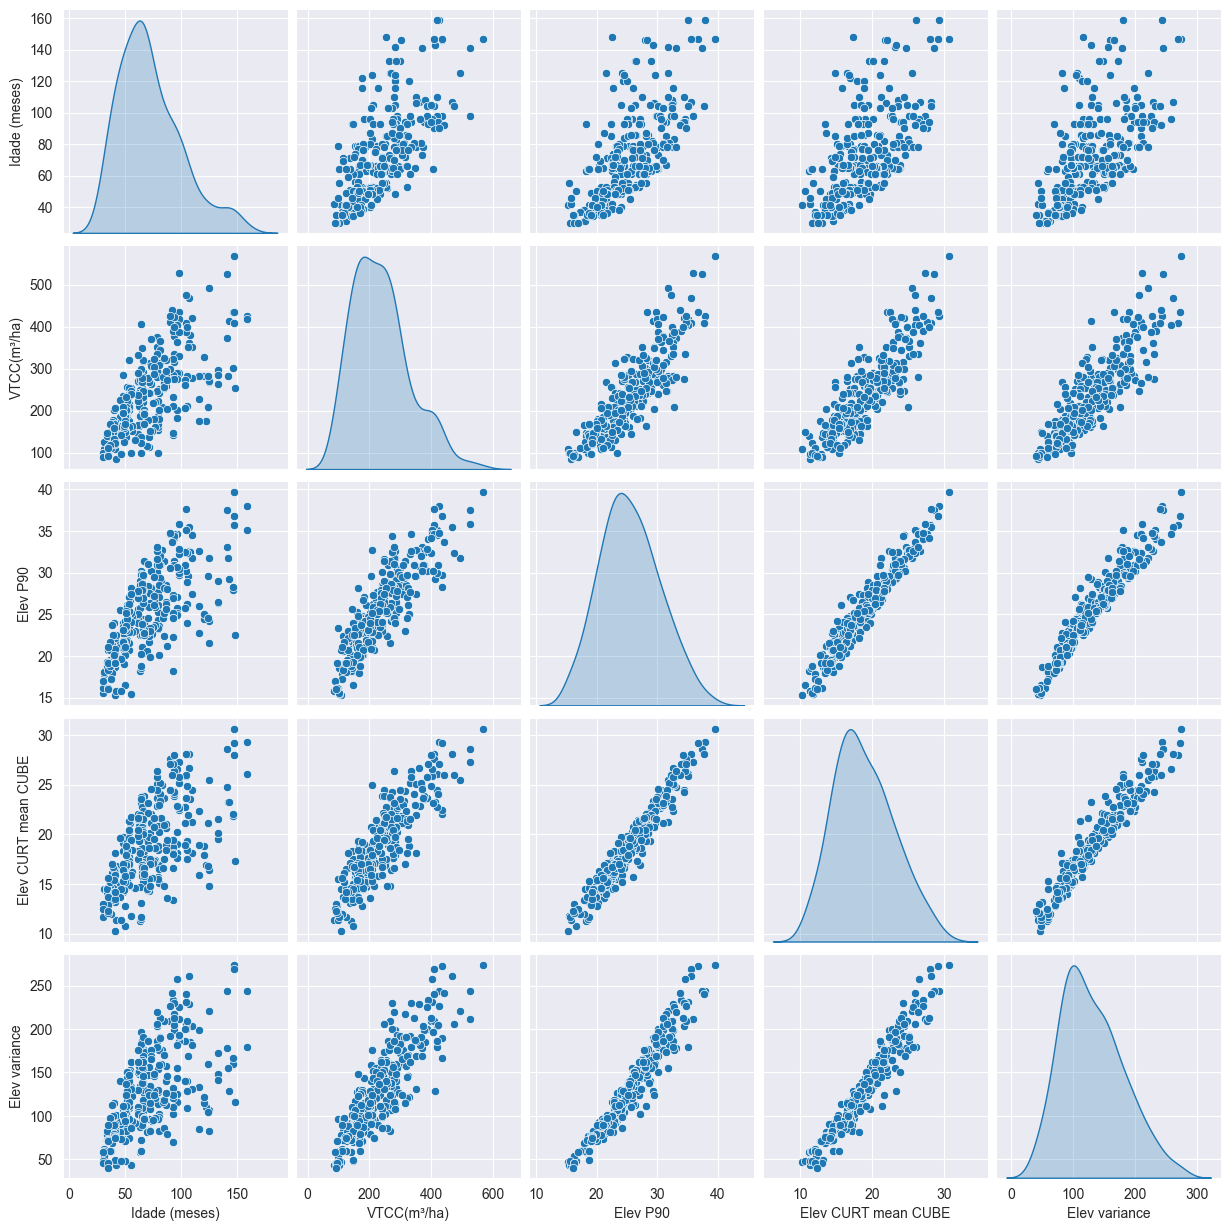

In [7]:
sns.pairplot(df[['Idade (meses)', 'VTCC(m³/ha)',"Elev P90", "Elev CURT mean CUBE", 'Elev variance']], diag_kind="kde")
plt.show()

In [8]:
# Redundant variables drop
df = df.drop(['Chave Parcela', 'Parcelas LiDAR', 'Parcela', 'LOTE_CODIGO', 'PROJETO_NOME', 'TALHAO_CODIGO', 'AREA_ESTRATO', 'TALHAO_AREA', 'SUBREGIAO_NOME', 'NUM_MEDICAO', 'ANO_MANEJO', 'CICLO', 'ROTACAO', 'INICIO_ROTACAO', 'MG_NOME', 'MG_TIPO', 'REGIAO_NOME', 'DESCTIPOPROPRIEDADE', 'DATA_MEDICAO',  'PROJETO_CODIGO', 'LOTE_AREA', 'Comprimento (m)', 'Comp.Dec (o)', 'Largura (m)', 'Larg.Dec (o)', 'Área (m²)', 'Área.corrigida (m²)', 'Medição', 'HT.média (m)', 'Dap.médio (cm)', 'Área basal (m²)', 'Fustes (n)', 'Fustes (n/ha)', 'VTCC(m³/Fuste)', 'DataFile', 'Idade (anos)', 'FileTitle'], axis=1)
# Caterogical variables to OHE
sel_cols = list(df.select_dtypes(include='object'))
dfd = pd.get_dummies(df, columns=list(df.select_dtypes(include='object')))
# Drop columns with zero variance
dfd = dfd.loc[:, dfd.var() != 0]
df_corr = dfd.corrwith(df['VTCC(m³/ha)'], numeric_only=True, method='pearson').to_dict()

C:\Users\Leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


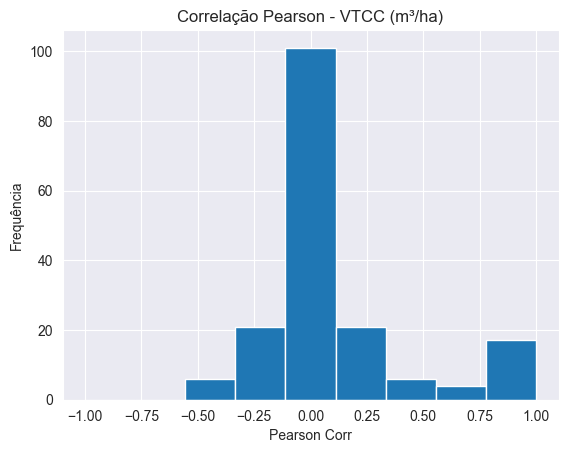

0) VTCC(m³/ha): 1.0
1) Elev CURT mean CUBE: 0.8756045654683235
2) Elev P90: 0.8681810620022306
3) Elev P80: 0.8666294859433659
4) Elev SQRT mean SQ: 0.8661372973639264
5) Elev P95: 0.8655531702287267
6) Elev variance: 0.8646608277386986
7) Elev P99: 0.8598059931268959
8) Elev L2: 0.8595391719108874
9) Elev stddev: 0.85670018238157
10) Elev P75: 0.8532309750740069
11) Elev IQ: 0.8391830235741513
12) Elev L1: 0.8281451529289098
13) Elev mean: 0.8281451529289098
14) Elev P70: 0.8256320903044092
15) Elev AAD: 0.8205266635293739
16) Elev maximum: 0.8149595069170632
17) Elev P60: 0.7611306434644723
18) Idade (meses): 0.6952573276706281
19) Elev MAD mode: 0.6553692380046245
20) Elev P50: 0.6523447289295193
21) Elev L4: -0.5053698925102625


In [9]:
# Pearson correlation graph
myList = df_corr.items()
myList = sorted(myList)
x, y = zip(*myList)
plt.hist(y, bins=list(np.linspace(-1,1,10)))
plt.xlabel('Pearson Corr')
plt.ylabel('Frequência')
plt.title('Correlação Pearson - VTCC (m³/ha)')
plt.show()

# Highest and lowest pearson correlation variables
vars = {k: v for k, v in df_corr.items() if v >= .5 or v <= -.5}
dfm = df[[*vars]]
vars_sort = list(reversed(sorted(vars.items(), key=lambda item: item[1])))
for k, v in enumerate(vars_sort):
    print(f"{k}) {v[0]}: {v[1]}")
    

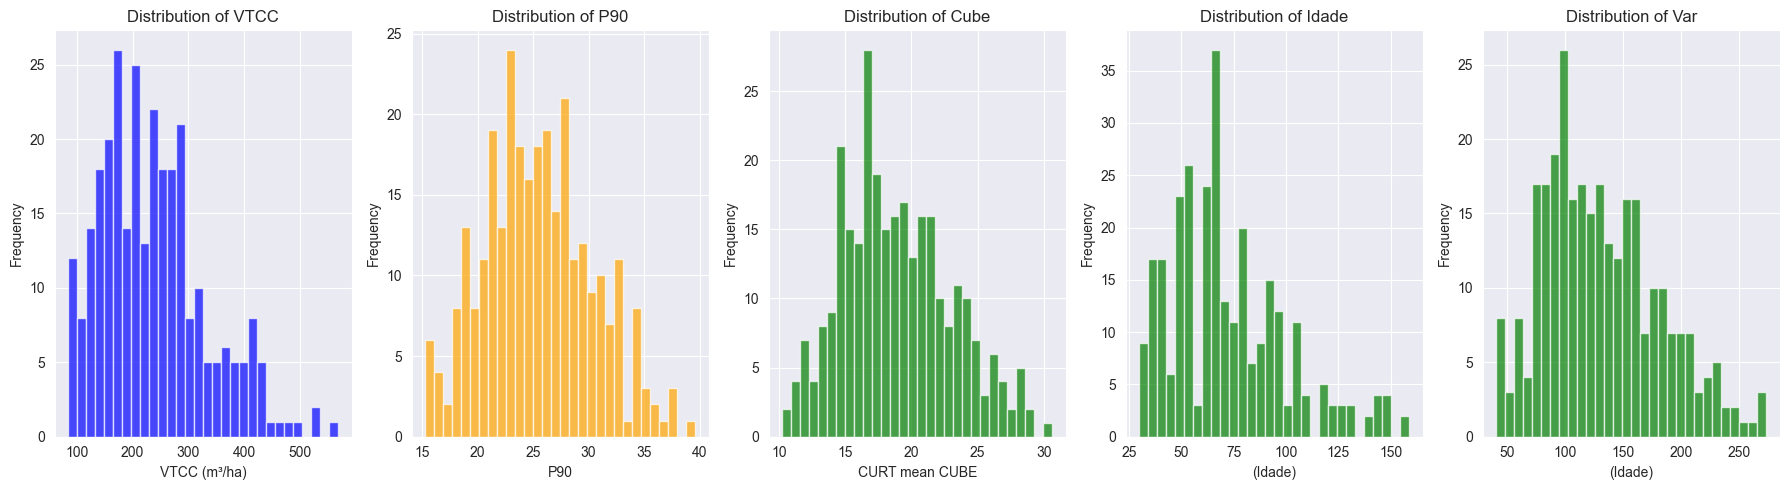

In [10]:
# Create a new figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 5, figsize=(18, 5))

# Histogram for VTCC
axs[0].hist(df['VTCC(m³/ha)'], bins=30, color='blue', alpha=0.7)
axs[0].set_xlabel('VTCC (m³/ha)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of VTCC')

# Histogram for P90
axs[1].hist(df["Elev P90"], bins=30, color='orange', alpha=0.7)
axs[1].set_xlabel('P90')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of P90')

# Histogram for Cube
axs[2].hist(df["Elev CURT mean CUBE"], bins=30, color='green', alpha=0.7)
axs[2].set_xlabel('CURT mean CUBE')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Cube')

# Histogram for Idade
axs[3].hist(df["Idade (meses)"], bins=30, color='green', alpha=0.7)
axs[3].set_xlabel('(Idade)')
axs[3].set_ylabel('Frequency')
axs[3].set_title('Distribution of Idade')

# Histogram for Idade
axs[4].hist(df["Elev variance"], bins=30, color='green', alpha=0.7)
axs[4].set_xlabel('(Idade)')
axs[4].set_ylabel('Frequency')
axs[4].set_title('Distribution of Var')


# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
# Map 'Regime' values to binary
df['Regime'] = df['Regime'].map({'REF': 0.5, 'REG': 0.8})

In [12]:
# Separate labels (target variable)
Y = df[['VTCC(m³/ha)']].values.astype(float)
X = df[["Elev P90", "Elev CURT mean CUBE", "Elev variance" , 'Idade (meses)']].values.astype(float)

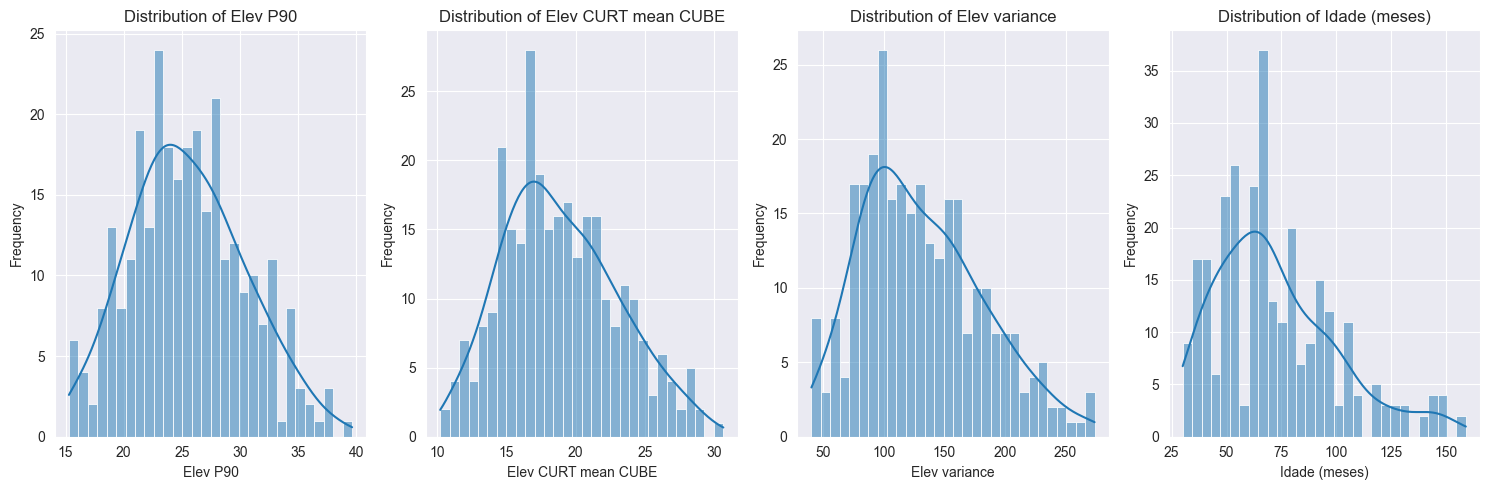

In [14]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 5))

# Plot each variable's distribution
for i, column in enumerate(["Elev P90", "Elev CURT mean CUBE", "Elev variance", "Idade (meses)"]):
    plt.subplot(1, 4, i + 1)  # Create a subplot for each variable
    sns.histplot(X[:, i], bins=30, kde=True)  # Histogram with kernel density estimate
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [27]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [28]:
rf = RandomForestRegressor(random_state = 42, n_jobs=-1)
# O RandomizedSearchCV é uma técnica de busca de hiperparâmetros que é usada para encontrar as melhores combinações de hiperparâmetros para um modelo de aprendizado de máquina, como o Random Forest Regressor.
# Numero de arvores no random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 20)]
# Numero de variaveis a serem consideradas a cada divisão
max_features = ['sqrt', 'log2', 1, .2, .3, .4, .5, .8]
# Numero maximo de niveis em uma arvore
max_depth = [int(x) for x in np.linspace(10, 150, num = 10)]
max_depth.append(None)
# Numero minimo de amostras queridas para divisao de cada nó
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# Numero minimo de amostras requeridas a cada nó
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Metodo de selecao de amostras para treinamento de cada arvore
bootstrap = [True, False]
# Criação de grid aleatório
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [29]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [30]:
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 25, 41, 56, 72, 87,
                                                      103, 118, 134, 150,
                                                      None],
                                        'max_features': ['sqrt', 'log2', 1, 0.2,
                                                         0.3, 0.4, 0.5, 0.8],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11,
                                                              12],
                                        'n_estimators': [10, 62, 114, 166, 218,
                                                         270, 322, 374, 426,
                                                         478, 531, 583, 635,
                                                         687, 739, 791, 843,
                                                         895, 947, 1000]},
                   random_state=42, verbose=2)

In [31]:
rfReg = RandomForestRegressor(n_estimators=rf_random.best_params_["n_estimators"], min_samples_split=rf_random.best_params_["min_samples_split"],
                              min_samples_leaf=rf_random.best_params_["min_samples_leaf"], max_features=rf_random.best_params_["max_features"],
                              max_depth=rf_random.best_params_["max_depth"], bootstrap=rf_random.best_params_["bootstrap"], random_state= 42).fit(x_train, y_train)

In [32]:
# Make predictions with the best model
train_predictions = rfReg.predict(x_train).flatten()
test_predictions = rfReg.predict(x_test).flatten()

# Calculate residuals as percentages
train_residuals = (np.array(y_train) - train_predictions) / np.array(y_train)
test_residuals = (np.array(y_test) - test_predictions) / np.array(y_test)

In [37]:
er = np.mean(train_residuals)*100
er2 = np.mean(test_residuals)*100

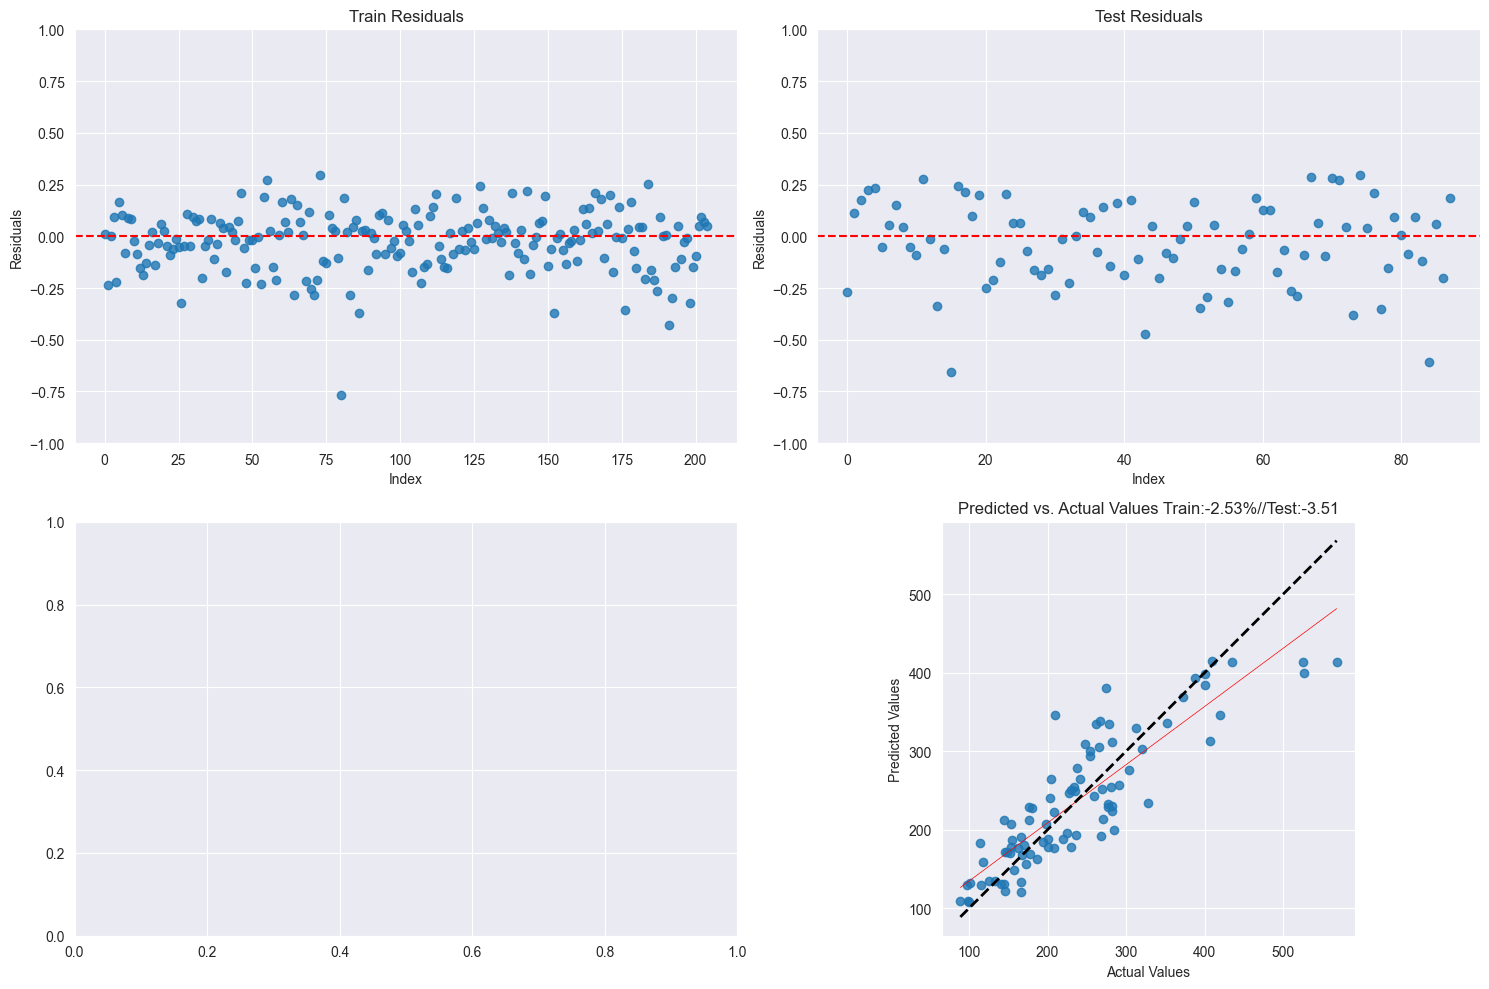

In [38]:
# Create a figure with 3 subplots arranged in a 2x2 grid (1 empty subplot)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

### Plot 1: Residual Plot ###
# Train Residuals
axs[0, 0].scatter(np.arange(len(train_residuals)), train_residuals, alpha=0.8)
axs[0, 0].set_ylim(-1, 1)  # Set y-axis limits
axs[0, 0].axhline(y=0, color='r', linestyle='--')
axs[0, 0].set_title("Train Residuals")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Residuals")

# Test Residuals
axs[0, 1].scatter(np.arange(len(test_residuals)), test_residuals, alpha=0.8)
axs[0, 1].set_ylim(-1, 1)  # Set y-axis limits
axs[0, 1].axhline(y=0, color='r', linestyle='--')
axs[0, 1].set_title("Test Residuals")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_ylabel("Residuals")

### Plot 3: Predicted vs. Actual Values with Trend Line ###
sns.regplot(x=y_test, y=test_predictions, ci=None, line_kws={"color": 'red', "linewidth": .5},
            scatter_kws={"alpha": 0.8}, ax=axs[1, 1])
lims = [
    np.min([y_test.min(), test_predictions.min()]),  # min of both axes
    np.max([y_test.max(), test_predictions.max()]),  # max of both axes
]
axs[1, 1].plot(lims, lims, 'k--', lw=2)  # Dashed black line
axs[1, 1].set_aspect('equal', adjustable='box')
axs[1, 1].set_xlabel('Actual Values')
axs[1, 1].set_ylabel('Predicted Values')
axs[1, 1].set_title(f'Predicted vs. Actual Values Train:{er:.2f}%//Test:{er2:.2f}')
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### Aplicação dos modelos e norms

In [92]:
# Function to read TIFF image and convert to NumPy array
def read_tif_to_array(file_path, reshape=True):
    with Image.open(file_path) as img:
        # Convert the image to a NumPy array
        array = np.array(img)
        if reshape:
            array = array.reshape(-1, 1)
            return array
        else:
            return array

In [93]:
def productivity(m, variables: list):
    
    np_p90 = read_tif_to_array(variables[0], True)
    np_cube = read_tif_to_array(variables[1], True)
    np_idade = read_tif_to_array(variables[2], True)
    np_mask = read_tif_to_array(variables[3], True)
    np_regime = read_tif_to_array(variables[4], True)
    np_var = read_tif_to_array(variables[5], True)

    stacked = np.hstack((np_p90, np_cube, np_var, np_idade))
    predictions = m.predict(stacked).reshape(-1, 1)
    
    # result = predictions * np_mask
    
    shape = read_tif_to_array(variables[0], False).shape
    result_image = predictions.reshape(shape)
    
    img = predictions.flatten()
    img_limpo = [x for x in img if str(x) != 'nan']

    return result_image, img_limpo

In [94]:
def find_duplicate_filenames(root_dir):
    # Dictionary to hold file names as keys and their paths as values
    files_dict = defaultdict(list)

    # Walk through all files and folders in the directory
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            # Store file paths under their filename
            files_dict[filename].append(os.path.join(dirpath, filename))

    # Filter to find files with more than one path (duplicates)
    duplicates = {filename: paths for filename, paths in files_dict.items() if len(paths) > 1}

    return duplicates

In [95]:
# Example usage
root_directory = "G:\PycharmProjects\LiDAR\Preditivo\Projetos_valid_modelo_preditivo"
duplicates = find_duplicate_filenames(root_directory)

In [96]:
results_df = pd.DataFrame(columns=['Talhao', 'Prod'])
for key, vals in duplicates.items():
    selected_vals = [vals[i] for i in [3, 0, 1, 2, 4, 5] if i < len(vals)]
    prod_img, array = productivity(rfReg, selected_vals)
    prod = np.average(array)
    # Append the results to the DataFrame
    results_df.loc[len(results_df)] = [key, prod]

In [97]:
conf = pd.read_excel(r'G:\PycharmProjects\LiDAR\Preditivo\Conferencia_IFPC.xlsx')
results_df['Talhao'] = results_df['Talhao'].str[:-4]

In [98]:
merged_left = pd.merge(conf, results_df, on='Talhao', how='left')

In [99]:
# Filter out rows where 'Prod' is NaN and create a copy
filtered_df = merged_left[merged_left['Prod'].notna()].copy()
filtered_df = filtered_df[filtered_df['Verificacao'] == 'Normal'] 
filtered_df = filtered_df[filtered_df['Idade'] < 200] 
# Now it's safe to add a new column without triggering a warning
filtered_df['res'] = (filtered_df['Prod IPC'] - filtered_df['Prod']) / filtered_df['Prod IPC']
filtered_df['IPC_pond'] = filtered_df['Prod IPC']*filtered_df['Area']
filtered_df['Lidar_pond'] = filtered_df['Prod']*filtered_df['Area']
filtered_df['Regional'] = filtered_df['Talhao'].str[:2]

s_1 = filtered_df['IPC_pond'].sum()/filtered_df['Area'].sum()
s_2 = filtered_df['Lidar_pond'].sum()/filtered_df['Area'].sum()

In [100]:
ref = filtered_df[filtered_df['Regime'] == "Alto Fuste"]
ref_1 = ref['IPC_pond'].sum()/ref['Area'].sum()
ref_2 = ref['Lidar_pond'].sum()/ref['Area'].sum()
ref_er = (ref_1-ref_2)/ref_1*100

In [101]:
reg = filtered_df[filtered_df['Regime'] == "Talhadia"]
reg_1 = reg['IPC_pond'].sum()/reg['Area'].sum()
reg_2 = reg['Lidar_pond'].sum()/reg['Area'].sum()
reg_er = (reg_1-reg_2)/reg_1*100

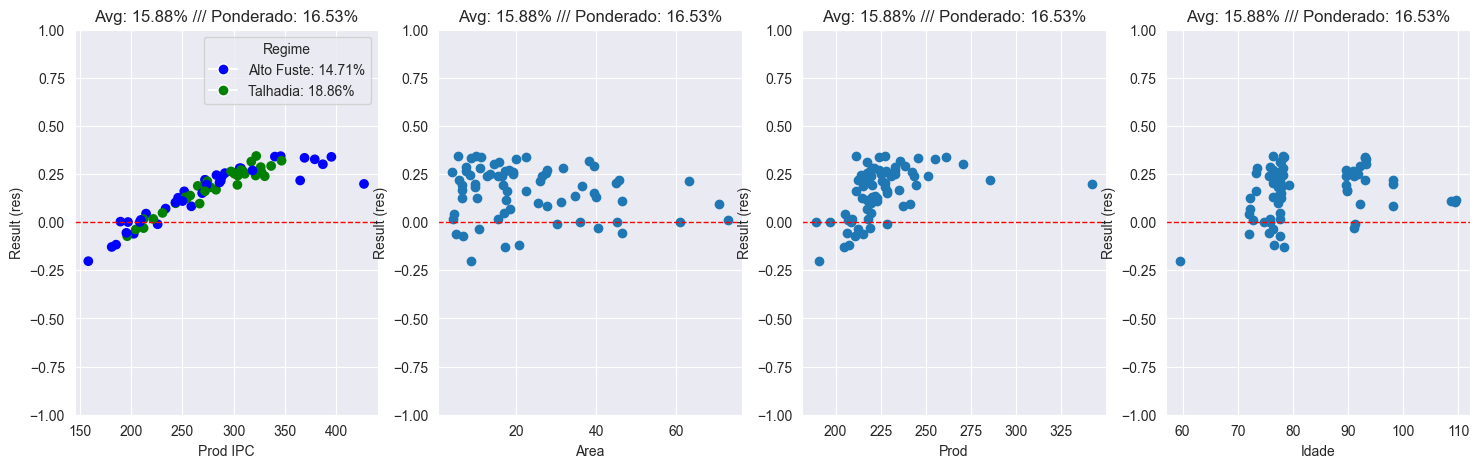

In [102]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
# Create a color mapping based on the 'Regime' column
color_mapping = {
    f'Alto Fuste' : 'blue',  # Example color for 'Alto Fuste'
    f'Talhadia': 'green',    # Example color for 'Talhadia'
    # Add more regimes and colors as needed
}

# Get colors based on the 'Regime' in filtered_df
colors = filtered_df['Regime'].map(color_mapping)

axs[0].scatter(filtered_df['Prod IPC'], filtered_df['res'], c=colors)
axs[0].axhline(0, color='red', linestyle='--', linewidth=1)
axs[0].set_ylim(-1, 1)
# Show the plot
axs[0].set_xlabel('Prod IPC')
axs[0].set_ylabel('Result (res)')
axs[0].set_title(f'Avg: {filtered_df.res.mean()*100:.2f}% /// Ponderado: {(s_1-s_2)/s_1*100:.2f}%')
# Optional: Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[regime], markersize=8) for regime in color_mapping]
labels = [
    f'{regime}: {ref_er:.2f}%' if regime == 'Alto Fuste' else f'{regime}: {reg_er:.2f}%' 
    for regime in color_mapping
]  # Add formatting for the error values
axs[0].legend(handles, labels, title='Regime')

axs[1].scatter(filtered_df['Area'], filtered_df['res'])
axs[1].axhline(0, color='red', linestyle='--', linewidth=1)
axs[1].set_ylim(-1, 1)
# Show the plot
axs[1].set_xlabel('Area')
axs[1].set_ylabel('Result (res)')
axs[1].set_title(f'Avg: {filtered_df.res.mean()*100:.2f}% /// Ponderado: {(s_1-s_2)/s_1*100:.2f}%')

axs[2].scatter(filtered_df['Prod'], filtered_df['res'])
axs[2].axhline(0, color='red', linestyle='--', linewidth=1)
axs[2].set_ylim(-1, 1)
# Show the plot
axs[2].set_xlabel('Prod')
axs[2].set_ylabel('Result (res)')
axs[2].set_title(f'Avg: {filtered_df.res.mean()*100:.2f}% /// Ponderado: {(s_1-s_2)/s_1*100:.2f}%')

axs[3].scatter(filtered_df['Idade'], filtered_df['res'])
axs[3].axhline(0, color='red', linestyle='--', linewidth=1)
axs[3].set_ylim(-1, 1)
# Show the plot
axs[3].set_xlabel('Idade')
axs[3].set_ylabel('Result (res)')
axs[3].set_title(f'Avg: {filtered_df.res.mean()*100:.2f}% /// Ponderado: {(s_1-s_2)/s_1*100:.2f}%')

plt.show()

In [103]:
NE = filtered_df[filtered_df['Regional'] == "NE"]
NE_1 = NE['IPC_pond'].sum()/NE['Area'].sum()
NE_2 = NE['Lidar_pond'].sum()/NE['Area'].sum()
NE_er = (NE_1-NE_2)/NE_1*100

GN = filtered_df[filtered_df['Regional'] == "GN"]
GN_1 = GN['IPC_pond'].sum()/GN['Area'].sum()
GN_2 = GN['Lidar_pond'].sum()/GN['Area'].sum()
GN_er = (GN_1-GN_2)/GN_1*100

RD = filtered_df[filtered_df['Regional'] == "RD"]
RD_1 = RD['IPC_pond'].sum()/RD['Area'].sum()
RD_2 = RD['Lidar_pond'].sum()/RD['Area'].sum()
RD_er = (RD_1-RD_2)/RD_1*100

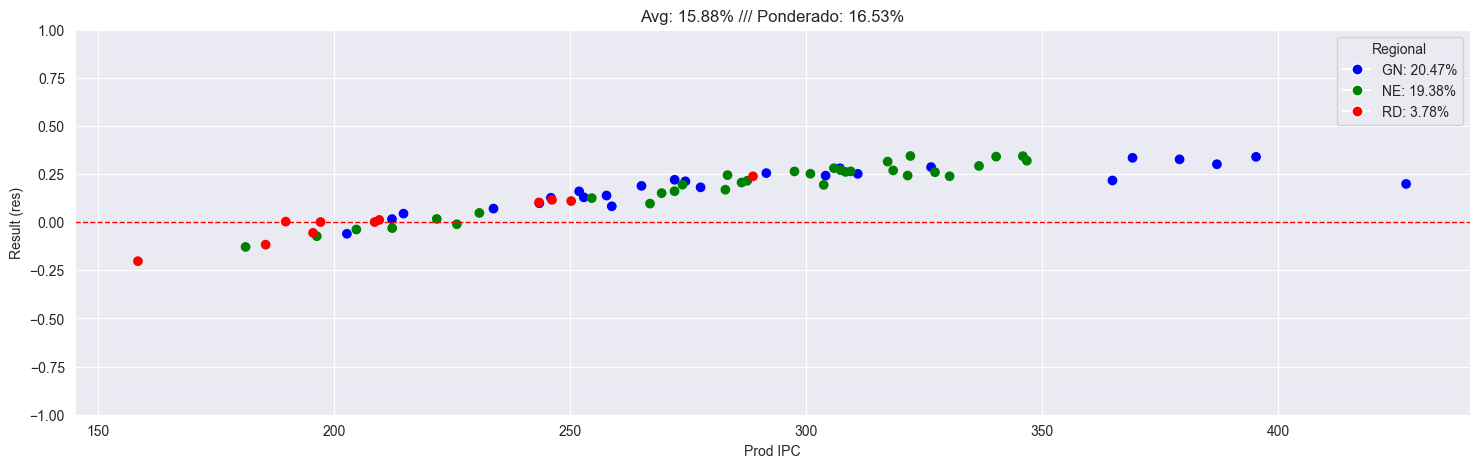

In [104]:
# Create a color mapping based on the 'Regime' column
color_mapping = {
    f'GN' : 'blue',  # Example color for 'Alto Fuste'
    f'NE': 'green',
    'RD': 'red' # Example color for 'Talhadia'
    # Add more regimes and colors as needed
}
# Create figure and axis
fig, ax = plt.subplots(figsize=(18, 5))

# Get colors based on the 'Regional' in filtered_df
colors = filtered_df['Regional'].map(color_mapping)

# Scatter plot
scatter = ax.scatter(filtered_df['Prod IPC'], filtered_df['res'], c=colors)

# Draw a horizontal line at y=0
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_ylim(-1, 1)

# Set labels and title
ax.set_xlabel('Prod IPC')
ax.set_ylabel('Result (res)')
ax.set_title(f'Avg: {filtered_df.res.mean()*100:.2f}% /// Ponderado: {(s_1-s_2)/s_1*100:.2f}%')

# Optional: Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[regional], markersize=8) for regional in color_mapping]
labels = [
    f'{regime}: {NE_er:.2f}%' if regime == 'NE' else 
    f'{regime}: {GN_er:.2f}%' if regime == 'GN' else 
    f'{regime}: {RD_er:.2f}%' 
    for regime in color_mapping
]

ax.legend(handles, labels, title='Regional')

# Show the plot
plt.show()